# 1. Why do we need to study medical imaging?
Though medical imaging is more than radiology, there is simply a vast shortage of radiologists. The demand for medical imaging increases as the world population ages and raises their quality of live, but the number of radiologists isn't growing to meet that demand. For exammple, from "2010 to 2020, the number of Diagnostic Radiology trainees ...increased just 2.5% compared to a 34% increase in the number of adults over 65" (rsna.org [article](https://https://www.rsna.org/news/2022/may/Global-Radiologist-Shortage)). 

In short, the radiologists of tomorrow will depend on AI assitance to meet demand for imaging diagnoses. More importantly, the radiologists of today already need a hand. Burnout rates among radiologists are increasing and regions with few or small urban centers are particularly feeling their diagnostic radiology needs unmet (acr.org [article](https://www.acr.org/Practice-Management-Quality-Informatics/ACR-Bulletin/Articles/March-2022/The-Radiology-Labor-Shortage)).

# 2. What are the categories?
Radiology is but one type of medical imaging, and even then it is a broad field. Radiology includes X-Rays, CT (computed axial tomography), MRI (magnetic resonance imaging), Ultrasound, Fluoroscopy, and more. And beyond radiology, many medical tests include microscopic analysis of blood ans other tissues.

# 3. Why is it important?
Technology directed at aiding diagnoses and healthcare actions based on medical imaging can improve the quality of medical care. The time efficiency of computers can also lower the costs to this care and make it available to greater numbers of people. Furthermore, the technology necessary for making these impacts is available and the methods for its construction are public knowledge.

# 4. What are the major applications? 
AI/ML methods for medical imaging can speed up response time to patients, improve and standarize accuracy, and enable hospitals in remote regions with limited resources to have their images read.


In [1]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random
import tensorflow as tf
import time
from PIL import Image
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
import requests



# We're going to load in CIFAR10, a massive dataset with low resolution images in 10 categories. It's perfect for learning to build classifying ML models

In [2]:
data = tf.keras.datasets.cifar10.load_data()

### the categories are below, they're numbers in the dataset, so let's also keep track of the actual words

In [3]:
lbls_str = ("airplane automobile bird cat deer dog frog horse ship truck")

In [4]:
lbls_lst = lbls_str.split()
lbls_lst

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
(x_train, y_train), (x_test, y_test) = data

### there are 50k training images and 10k testing images, but we'll use only a few thousand so tests can be quick


In [6]:
for arr in [x_train, y_train, x_test, y_test ]:
    print(arr.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


### this histogram is a good idea because the training set's distribution should match the validation set's, and the validation set's should ABSOLUTELY match the test set's

### the splicing of the y_train below is a result of trying many different intervals, searching for histograms with more or less equal representation of all classes

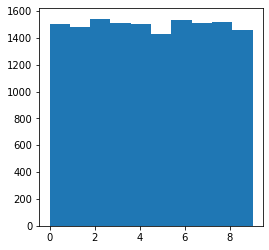

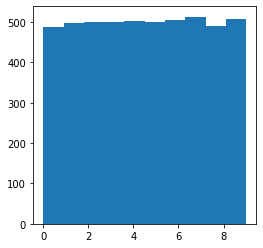

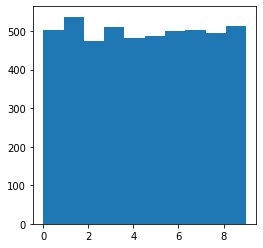

In [41]:
plt.figure(figsize=(4,4));
plt.hist(y_train[:15000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[15000:20000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[20000:25000]);

plt.show()

### this function will give us one hot vectors from the number corresponding to the classes, we know that  0 = airplane and 3 = cat, but the ML will have a better time if we have one hot vectors like <1,0,0,0,0,0,0,0,0,0> or <0,0,0,1,0,0,0,0,0,0>

In [42]:
def one_hot(vec):
    n = vec.shape[0]
    out = np.zeros((n, np.max(vec)+1))
    for i in range(n):
        out[i,vec[i][0]]=1
    return out

### let's look at an example to learn about one-hot

In [43]:
one_hot(np.array([[3],[5],[3],[0],[2],[1]]))

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

### using the intervals from earlier, we'll define a training, validation and testing set

(2000, 32, 32, 3) (2000, 1)


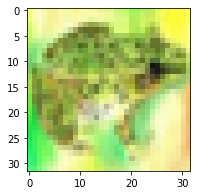

frog
(1000, 32, 32, 3) (1000, 1)


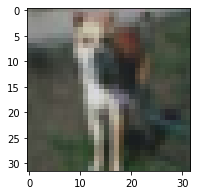

dog
(1000, 32, 32, 3) (1000, 1)


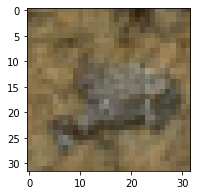

frog


In [44]:
xtr, xval, xtst = x_train[:2000],x_train[4500:5500],x_train[5500:6500]
ytr, yval, ytst = y_train[:2000],y_train[4500:5500],y_train[5500:6500]


for k in [(xtr,ytr),(xval,yval),(xtst,ytst)]:
    print(k[0].shape,k[1].shape)
    im = np.random.randint(0,500)
    #NOTE THAT THE IMAGES ARE 32 BY 32 BY 3 ARRAYS
    plt.figure(figsize=(3,3))
    plt.imshow(k[0][im])
    plt.show()
    print(lbls_lst[k[1][im][0]])

### it's always a good idea to save your work
#### note that there are validation and test sets. Validation sets are used to have your trained model predict on, and thus get an idea for its performance on 'unseen data' (data that the model didn't train on); this way, validation sets and their respective accuracy guide one's selection of hyperparameters and architectures. Test sets are never touched until the very end to give a final estimate of your model's performance on unseen data.

In [45]:
vtr,vval,vtst = one_hot(ytr),one_hot(yval),one_hot(ytst)
np.save('xtr',xtr)
np.save('vtr',vtr)
np.save('xval',xval)
np.save('vval',vval)
np.save('xtst',xtst)
np.save('vtst',vtst)

## Let's build some AI models on this data

In [46]:
print('our whole training data has shape: ',xtr.shape)
print('\nand our training set of labels haa shape: ',vtr.shape)

our whole training data has shape:  (2000, 32, 32, 3)

and our training set of labels haa shape:  (2000, 10)


### we can start with a basic neural net, a function will help so we can make the AI model whenever and we don't have to copy code

In [57]:
def generate_basic_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    #keras likes tensors
    #BTW A TENSOR IS ANY ARRAY AND OFTEN REFERS TO ARRAYS WITH MORE THAN 2 AXES 
    #e.g.:  rows, columns, color channels (RGB)
    #vectors are groups of number, matrices are groups of vectors, 
    #tensors are groups of matrices (or other tensors)
    #there's no need to be afraid of tensors
  
    flat= Flatten()(input_tensor)
    #neural nets like flat input, notice how the result of one line 
    #is the input to the next
    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(flat)
    #cool kids use regularization
    #regularization helps prevent overfitting
    
    # Note that the relu activation function is often used. It has been the
    # bread and butter of machine learning projects for years.

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC3)
    
    # Note that the softmax activation function is added at the end. This 
    # is a function that turns an array of values into a group of probabilities.
    # In this way, it's very useful for single class categorization tasks.
    
    
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=1e-1),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [58]:
basicAI = generate_basic_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                170       
Total params: 199,450
Trainable params: 199,450
Non-trainable params: 0
_____________________________________________________

### you just made an AI MODEL! now let's train it
#### Note that we use the variables 'vtr' and 'vval' for the labels, because the y values came as scalars

In [59]:
basicAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 15)

Epoch 1/15
63/63 [==============================] - 0s 3ms/step - loss: 1940.4546 - accuracy: 0.1035 - val_loss: 382.5786 - val_accuracy: 0.0900
Epoch 2/15
63/63 [==============================] - 0s 2ms/step - loss: 323.7853 - accuracy: 0.0960 - val_loss: 267.9725 - val_accuracy: 0.0900
Epoch 3/15
63/63 [==============================] - 0s 2ms/step - loss: 226.2558 - accuracy: 0.0935 - val_loss: 187.4725 - val_accuracy: 0.1090
Epoch 4/15
63/63 [==============================] - 0s 2ms/step - loss: 158.3020 - accuracy: 0.0925 - val_loss: 131.1658 - val_accuracy: 0.1090
Epoch 5/15
63/63 [==============================] - 0s 2ms/step - loss: 110.8016 - accuracy: 0.1005 - val_loss: 91.9026 - val_accuracy: 0.1090
Epoch 6/15
63/63 [==============================] - 0s 2ms/step - loss: 77.8198 - accuracy: 0.0905 - val_loss: 64.7677 - val_accuracy: 0.0980
Epoch 7/15
63/63 [==============================] - 0s 2ms/step - loss: 55.0794 - accuracy: 0.0960 - val_loss: 46.1043 - val_accuracy: 0.1

### and now let's try and predict an image's category (though accuracy is less than chance)

In [60]:
np.round(basicAI.predict(xval[305:310,:,:,:]),2),vval[305:310]

(array([[0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09]],
       dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

### we might not be able to publish this model in Nature...
### let's try a convolutional neural network
Note that errors can often be hard parts of getting started with the major machine learning libraries. It's ok. Looking up errors on google or sites like stack overflow can provide fantastic responses, and the sites housing the libraries in question are also great (https://www.tensorflow.org/)

In [82]:
def generate_conv_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    
    #the kernel size will be set to 3 by 3 pixels
    #the 4, 8, and 12 in the next layers are the channels future layers will have
    #for example, the first layer here will make 4 convolutional filters that will 
    
    REG = 1e-2
    LR = 3e-1
    
    c1 = Conv2D(8, kernel_size=(3, 3),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(input_tensor) 
    c2 = Conv2D(16, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c1)
    c3 = Conv2D(32, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c2)
    
    mp1 = tf.keras.layers.MaxPool2D()(c3)
    # max pooling layers can help convolutional models
    
    c4 = Conv2D(8, kernel_size=(3, 3),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(mp1) 
    c5 = Conv2D(16, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c4)
    c6 = Conv2D(32, kernel_size=(3, 3), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c5)
    
    mp2 = tf.keras.layers.MaxPool2D()(c6)
  
    flat= Flatten()(mp2)

    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(flat)

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(REG))(FC3)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=LR),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [106]:
convAI = generate_conv_model()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 30, 30, 8)         224       
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 11, 11, 8)         2312      
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 9, 9, 16)          116

In [107]:
record = convAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 15)

Epoch 1/15
63/63 [==============================] - 2s 28ms/step - loss: 645241700352.0000 - accuracy: 0.0970 - val_loss: 523.0645 - val_accuracy: 0.1070
Epoch 2/15
63/63 [==============================] - 1s 23ms/step - loss: 554.9332 - accuracy: 0.1130 - val_loss: 558.3987 - val_accuracy: 0.0900
Epoch 3/15
63/63 [==============================] - 1s 21ms/step - loss: 412585.4375 - accuracy: 0.0985 - val_loss: 557.2830 - val_accuracy: 0.1090
Epoch 4/15
63/63 [==============================] - 1s 23ms/step - loss: 558.6328 - accuracy: 0.1030 - val_loss: 556.5317 - val_accuracy: 0.1120
Epoch 5/15
63/63 [==============================] - 1s 22ms/step - loss: 555.2888 - accuracy: 0.1070 - val_loss: 554.1161 - val_accuracy: 0.0900
Epoch 6/15
63/63 [==============================] - 1s 21ms/step - loss: 553.1525 - accuracy: 0.0925 - val_loss: 552.1649 - val_accuracy: 0.0900
Epoch 7/15
63/63 [==============================] - 1s 22ms/step - loss: 551.3725 - accuracy: 0.1000 - val_loss: 550.5

### This model also isn't fantastic. That's OK, though, testing architectures and hyperparameters is a natural step in ML/AI, let's explore the output of the 'fit' function which we stored in the 'record' variable

In [103]:
record.history

{'loss': [326.596923828125,
  323.2759094238281,
  320.1441955566406,
  317.127197265625,
  314.2469787597656,
  311.4796142578125,
  308.7980651855469,
  306.2056884765625,
  303.6790771484375,
  301.23663330078125,
  298.8390808105469,
  296.50994873046875,
  294.24139404296875,
  292.0055847167969,
  289.8309326171875],
 'accuracy': [0.09549999982118607,
  0.09549999982118607,
  0.09849999845027924,
  0.10199999809265137,
  0.09350000321865082,
  0.09049999713897705,
  0.10350000113248825,
  0.0925000011920929,
  0.10300000011920929,
  0.08900000154972076,
  0.09449999779462814,
  0.09399999678134918,
  0.09200000017881393,
  0.09200000017881393,
  0.1054999977350235],
 'val_loss': [324.8678894042969,
  321.6305236816406,
  318.56591796875,
  315.6544494628906,
  312.8025207519531,
  310.0709228515625,
  307.4455261230469,
  304.8768005371094,
  302.44061279296875,
  300.0013427734375,
  297.6070251464844,
  295.32061767578125,
  293.0699462890625,
  290.8716125488281,
  288.7245788

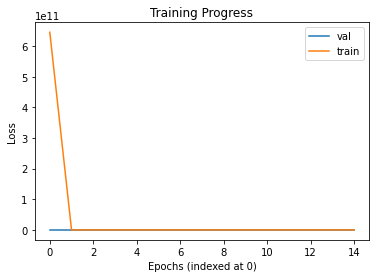

Text(0, 0.5, 'Accuracy (decimal)')

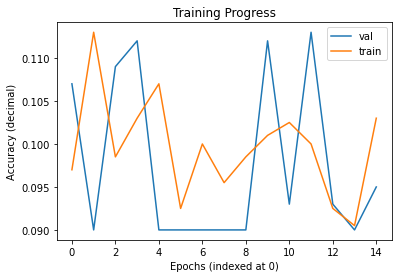

In [110]:
plt.plot(record.history['val_loss'])
plt.plot(record.history['loss'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Loss')
plt.legend(['val','train'])
plt.show()
#note that we will select good models based on the performance on the 
#validation set

plt.plot(record.history['val_accuracy'])
plt.plot(record.history['accuracy'])
plt.legend(['val','train'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Accuracy (decimal)')

In [88]:
def gen_model(lr =  1e-3, r = 1, input_shape = xtr[0].shape, 
              filter_size =3, fc_lst = [400,400,200], s = False):
    input_tensor = tf.keras.Input(shape=input_shape )
    """
    THIS ARCHITECTURE WAS INSPIRED BY VGG16 
    
    lr refers to learning rate
    r referes to L2 regularization rate 
    filter_size is used for vertical and horizontal dimension of all
        convolutional kernels in this model
    fc_lst defines the layers and cells following the convolutional 
        segment. For example, fc_lst = [400,200,100] will add three
        neural netowrk layers at the end of the model where the first
        has 400 cells and the last has 100 cells. 
        The final layer will always automatically have 10 cells for
        prediction and fc_lst must be a list of two or more numbers
    s takes a boolean deciding whether to print a keras summary
        of the model generated
    
    """
    c1 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                padding='same',
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(input_tensor) 
    c2 = Conv2D(8, kernel_size=(filter_size, filter_size),
                 padding='same',
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c1)
    c3 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                 padding='same',
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c2)
    l1 = tf.keras.layers.LayerNormalization()(c3)
    c4 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l1) 
    c5 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c4)
    c6 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c5)
    mp2 = tf.keras.layers.MaxPool2D()(c6)
    l2 = tf.keras.layers.LayerNormalization()(mp2)
    c7 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l2) 
    c8 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c7)
    c9 = Conv2D(32, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c8)
    mp3 = tf.keras.layers.MaxPool2D()(c9)
    l2 = tf.keras.layers.LayerNormalization()(mp3)
    ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ##
    flat= Flatten()(l2)
    for fc_dim in fc_lst[:-1]:
        FC = Dense(fc_dim, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
        flat = tf.keras.layers.LayerNormalization()(FC)
    flat = Dense(fc_lst[-1], activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    if s:
        model.summary()
    return model

### we can now easily generate different models
#### note that the summaries show 288 parameters after all the convolutions, so a number of cells much larger than that in the fc_lst may not be useful and could make the model slower with no benefit.
#### additionally, filter_size values above 4 will crash the model as the initial pixel count of 32 is too small to last through 9 such convolutions and a pair of max pooling layers

In [90]:
for fc_lst in [[200,200,200],[100,100],[200,150,150,50,50]]:
    model =gen_model(fc_lst = fc_lst,s=True)
    print('\n\n')

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 32, 32, 8)         584       
_________________________________________________________________
layer_normalization_90 (Laye (None, 32, 32, 8)         16        
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 30, 30, 16)        1168      
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 28, 28, 16)        232

In [117]:
for fc_lst in [[128,128,128],[64,64,32,16]]:
    for filter_size in [2,3]:
        for i in range(3):
            #we will train every model 3 times with different learning rate and
            #regularization hyperparameters
            LRlog = np.random.rand()*3 - 4
            REGlog = np.random.rand()*3 - 3
            #note that this rand function gives a number from a uniform distribution
            #a number from a normal distribution wouldn't be ideal
            LR = 10**(LRlog)
            REG = 10**(REGlog)
            #we're exploring the hyperparemeter space of LR and REG
            #logarithmically, so various magnitudes are equally represented
            #if we took a random number from 1e-4 to 1e-1 directly, 
            #the lower magnitudes wouldn't come up often
            model =gen_model(fc_lst = fc_lst,
                             filter_size=filter_size,
                             lr= LR, r = REG, s=True)
            print('\nMODEL (fc_lst, filter_size, LR, REG): ',
                  fc_lst, filter_size, np.round(LR,5), np.round(REG,4),
                 '\n\n')
            #the np.round() function is fantastic for the eyes
            record = model.fit(xtr,vtr,validation_data=(xval,vval), epochs = 8)
            

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 32, 32, 8)         104       
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 32, 32, 8)         264       
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 32, 32, 8)         264       
_________________________________________________________________
layer_normalization_150 (Lay (None, 32, 32, 8)         16        
_________________________________________________________________
conv2d_315 (Conv2D)          (None, 31, 31, 16)        528       
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 30, 30, 16)        104

## Now THOSE are some GOOOOD models!!

# Let's build a model with medical images. We'll use data from 

# "PadChest: A large chest x-ray image dataset with multi-label annotated reports" published in Medical Image Analysis (2020) by Bustos A., Pertusa A., Salinas J., de la Iglesia-Vayá M. https://bimcv.cipf.es/bimcv-projects/padchest/
## First we'll load the metada

In [2]:
N = 87
dim = 1200
xr_arr = np.load('resizedPadChest0.npy')
diag_arr = np.load('sickbin.npy')
xr_arr = xr_arr.reshape(N,dim,dim,1)
diag_arr = diag_arr.reshape(N,1)
print(xr_arr.shape, diag_arr.shape)

(87, 1200, 1200, 1) (87, 1)


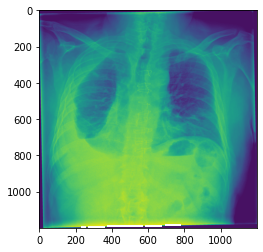

AND the matching value is  [1]  so the patient is ill. And chances are the patient would like to know...


In [3]:
plt.imshow(xr_arr[3])
plt.show()
print('AND the matching value is ',diag_arr[3], ' so the patient is ill. And chances are the patient would like to know...')

### these are 87 chest xray images with about a third of them healthy and a third of them suffering from a nondescribed ailment. We'll build a small model to try and catch abnormal images

### A 1 at location 'k' means that the image in 'xr_arr' at location 'k' is abnormal and has some visible disease

In [7]:
def gen_xr_model(lr =  1e-3, r = 1, input_shape = xr_arr[0].shape, 
              filter_size =4, fc_lst = [400,400,200], s = False):
    input_tensor = tf.keras.Input(shape=input_shape )
    """
    THIS ARCHITECTURE WAS INSPIRED BY VGG16 
    
    lr refers to learning rate
    r referes to L2 regularization rate 
    filter_size is used for vertical and horizontal dimension of all
        convolutional kernels in this model
    fc_lst defines the layers and cells following the convolutional 
        segment. For example, fc_lst = [400,200,100] will add three
        neural netowrk layers at the end of the model where the first
        has 400 cells and the last has 100 cells. 
        The final layer will always automatically have 21 cells for
        prediction and fc_lst must be a list of two or more numbers
    s takes a boolean deciding whether to print a keras summary
        of the model generated
        
    changes from earlier version of this function:
        last layer now has 21 cells and a sigmoid rather than softmax
        activation function, this allows one image to have multiple
        diagnoses. Padding was removed. default input shape changed
    
    """
    c1 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(input_tensor) 
    c2 = Conv2D(8, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c1)
    c3 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c2)
    mp1 = tf.keras.layers.MaxPool2D()(c3)
    l1 = tf.keras.layers.LayerNormalization()(mp1)
    c4 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l1) 
    c5 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c4)
    c6 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c5)
    mp2 = tf.keras.layers.MaxPool2D()(c6)
    l2 = tf.keras.layers.LayerNormalization()(mp2)
    c7 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l2) 
    c8 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c7)
    c9 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c8)
    mp3 = tf.keras.layers.MaxPool2D()(c9)
    l3 = tf.keras.layers.LayerNormalization()(mp3)
    c10 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l3) 
    c11 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c10)
    c12 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.l2(r))(c11)
    mp4 = tf.keras.layers.MaxPool2D()(c12)
    l4 = tf.keras.layers.LayerNormalization()(mp4)
    ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ##
    flat= Flatten()(l4)
    for fc_dim in fc_lst[:-1]:
        FC = Dense(fc_dim, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.l2(r))(flat)
        flat = tf.keras.layers.LayerNormalization()(FC)
    flat = Dense(fc_lst[-1], activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.l2(r))(flat)    
    predictions = Dense(1, activation = 'sigmoid', 
                        kernel_regularizer = tf.keras.regularizers.l2(r))(flat)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    if s:
        model.summary()
    return model

In [8]:
xr_ai = gen_xr_model(lr =  1e-3, r = 1, input_shape = xr_arr[0].shape, 
              filter_size =5, fc_lst = [48,40,32], s = True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1200, 1200, 1)]   0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1196, 1196, 8)     208       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1192, 1192, 8)     1608      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1188, 1188, 8)     1608      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 594, 594, 8)       0         
_________________________________________________________________
layer_normalization_12 (Laye (None, 594, 594, 8)       16        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 590, 590, 16)      3216

## Now you can train this and other models to develop a strong assistant to radiologists! 
### Hint: the techniques in the CIFAR dataset can work here!

In [ ]:
xr_ai.fit(
    x=xr_arr,
    y=diag_arr,
    batch_size=4,
    epochs=10)